# **요약**

## **인사이트 관련**

<table>
    <tr>
        <th>데이터 유형</th>
        <th>EDA 내용</th>
    <tr>
        <td rowspan = '3' valign = 'center' align = 'center'>인적 정보</td>
        <td>최근에 가입한 유저일 수록 이탈율이 높음</td>
    </tr>
    <tr>
        <!--<td>인적 정보</td>-->
        <td>10대 후반 ~ 20대 초반의 사용자가 타 연령대에 비해 이탈율이 높음</td>
    </tr>
    <tr>
        <!--<td>인적 정보</td>-->
        <td>가입 경로에 따라 이탈율에 큰 차이를 보임</td>
    </tr>
    <tr>
        <td rowspan = '2' valign = 'center' align = 'center'>사용 기록</td>
        <td>사용 기록이 많은 고객일 수록 이탈율이 낮음</td>
    </tr>
    <tr>
        <!--<td>사용 기록</td>-->
        <td>이탈 유저의 경우 장기간 미접속 경험 비율이 높음</td>
    </tr>
    <tr>
        <td rowspan = '4'  valign = 'center' align = 'center'>구매 기록</td>
        <td>고객이 선택하는 결제 수단에 따라 이탈율의 편차가 큼</td>
    </tr>
    <tr>
        <!--<td>구매 기록</td>-->
        <td>이탈 유저는 구독 자동 갱신 횟수가 적음</td>
    </tr>
    <tr>
        <!--<td>구매 기록</td>-->
        <td>구독 유지 기간이 길수록 이탈율은 낮아짐</td>
    </tr>
    <tr>
        <!--<td>구매 기록</td>-->
        <td>가입 이후 결제 방식을 변경한 고객의 이탈율이 더 높음</td>
    </tr>
</table>


## **전처리 및 스케일링 관련** 

<table>
    <tr>
        <th>데이터 유형</th>
        <th>EDA 내용</th>
    <tr>
        <td valign = 'center' align = 'center'>공통</td>
        <td >이탈 잔존 유저의 구성 비율이 불균형함</td>
    </tr>
    <tr>
        <td valign = 'center' align = 'center'>인적 정보</td>
        <td>성별, 나이 데이터에 결측치, 이상치가 다수 존재함</td>
    </tr>
    <tr>
        <td valign = 'center' align = 'center'>사용 기록</td>
        <td>음원 재생 관련 데이터에 이상치가 다수 존재함</td>
    </tr>
    <tr>
        <td valign = 'center' align = 'center'>구매 기록</td>
        <td>거래 일자와 구독 만료일 데이터에 이상치가 발견됨</td>
    </tr>
    </tr>
</table>

# **데이터 및 라이브러리 불러오기**

In [42]:
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy
from tqdm import tqdm
import numpy as np
import datetime

mpl.rcParams['font.family'] ='NanumGothic'
mpl.rcParams['axes.unicode_minus'] =False

user_logs = pd.read_parquet('./sample_user_logs (ratio=0.107).parquet')
transactions = pd.read_parquet('./sample_transactions (ratio=0.107).parquet')
train = pd.read_parquet('./sample_train (ratio=0.107).parquet')
members = pd.read_parquet('./sample_members (ratio=0.107).parquet')

# **EDA**

## **공통**

### **이탈 / 잔존 유저의 구성 비율이 불균형함**

* 이탈 유저와 잔존 유저의 비율이 대략 87 : 13으로 불균형함
* 해당 문제를 해결해야만 일반화 정도가 높은 머신 러닝 모델을 만들 수 있음

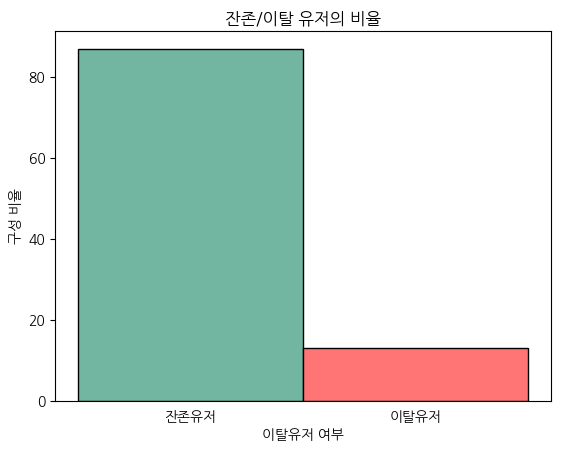

In [19]:
tmp = copy.deepcopy(train)
tmp.replace({'is_churn' : {0 : '잔존유저', 1 : '이탈유저'}}, inplace=True)
ax = sns.histplot(x = 'is_churn',
                  data = tmp,
                  stat = 'percent')
ax.patches[0].set_facecolor('#72B6A1')
ax.patches[1].set_facecolor('#FF7575')
plt.tick_params(bottom = False)
plt.xlabel('이탈유저 여부')
plt.ylabel('구성 비율')
plt.title('잔존/이탈 유저의 비율')
plt.gca().axes.yaxis.set_visible(True)
plt.show()

## **인적 정보 관련**

### **성별, 나이 데이터에 결측치, 이상치가 다수 존재함**

* 나이의 경우, 아래와 같은 이상치의 비중이 전체의 54%에 달함
    * 나이가 음수인 경우
    * 나이가 0세인 경우
    * 나이가 122세(최고 수명 기네스기록) 초과
* 성별의 경우, 결측치의 비중이 전체의 53%에 달함
* KKBox에 직접 가입하여 확인해본 결과, 나이와 성별은 사용자가 직접 입력해야 하며 해당 정보에 대한 별도의 인증 절차가 필요하지 않음

<p align = "left"><img src = "https://github.com/TAEJIN-AHN/Churn-Prediction/assets/125945387/48391415-a6e7-4d6a-b581-cc86b4333506" width = 40% height = 40%></p>

100%|██████████| 102773/102773 [00:21<00:00, 4845.99it/s]


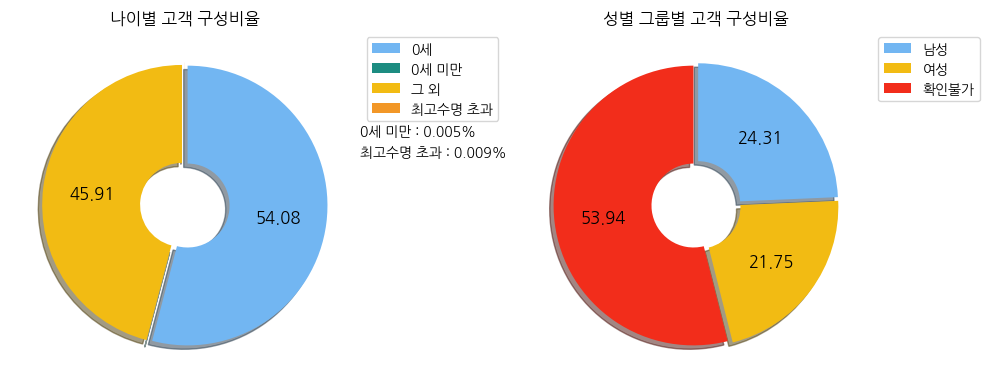

In [40]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# members, train 데이터 merge하기
df = train[['msno_num']].merge(members[['msno_num', 'bd']], on = 'msno_num', how = 'left')
df.columns = ['고객번호', '나이']
df.fillna(value = {'나이' : '확인불가'}, inplace = True)

# 데이터값에 따라 그룹만들기
for row_number in tqdm(range(df.shape[0])):
  if df.loc[row_number, '나이'] == '확인불가':
    df.loc[row_number, '세대'] = '확인불가'
  elif df.loc[row_number, '나이'] < 0:
    df.loc[row_number, '세대'] = '0세 미만'
  elif df.loc[row_number, '나이'] == 0:
    df.loc[row_number, '세대'] = '0세'
  elif (df.loc[row_number, '나이']>0) & (df.loc[row_number, '나이']<=122):
    df.loc[row_number, '세대'] = '그 외'
  elif df.loc[row_number, '나이']>122:
    df.loc[row_number, '세대'] = '최고수명 초과'
df_pivot = pd.DataFrame(df.groupby('세대', as_index = False)['고객번호'].count())

# 파이차트로 각 그룹별 구성비율 확인하기
colors = ['#72B6F2', '#1C8C81', '#F2BB13', '#F29727']
wedgeprops={'width': 0.7}
explode = [0.02, 0.02, 0.02, 0.02]

def my_autopct(pct):
  return ('%.2f' % pct) if pct > 10 else ''

ax1.pie(df_pivot['고객번호'], autopct = my_autopct, startangle = 90,
        counterclock = False, explode = explode,
        shadow = True, colors = colors, wedgeprops = wedgeprops,
        textprops = {'fontsize' : 12}, pctdistance = 0.65)
ax1.legend(df_pivot['세대'], bbox_to_anchor = (1, 1))
ax1.set_title('나이별 고객 구성비율')
ax1.annotate('0세 미만 : {}%'.format(round(df_pivot[df_pivot['세대'] == '0세 미만'].iloc[0, 1] / sum(df_pivot['고객번호']) * 100, 3)), (1.25, 0.5))
ax1.annotate('최고수명 초과 : {}%'.format(round(df_pivot[df_pivot['세대'] == '최고수명 초과'].iloc[0, 1] / sum(df_pivot['고객번호']) * 100, 3)), (1.25, 0.35))

# members, train 데이터 merge한 후, pivot 테이블 생성
df = train[['msno_num']].merge(members[['msno_num', 'gender']], on = 'msno_num', how = 'left')
df.columns = ['고객번호', '성별']
df.fillna(value = {'성별' : '확인불가'}, inplace = True)
df.replace({'성별' : {'donotknow' : '확인불가', 'male' : '남성', 'female' : '여성'}}, inplace = True)
df_pivot = pd.DataFrame(df.groupby('성별', as_index = False)['고객번호'].count())

# 파이차트로 각 그룹별 구성비율 확인하기
colors = ['#72B6F2', '#F2BB13', '#F22D1B']
wedgeprops={'width': 0.7}
explode = [0.02, 0.02, 0.02]

ax2.pie(df_pivot['고객번호'], autopct = my_autopct, startangle = 90,
        counterclock = False, explode = explode,
        shadow = True, colors = colors, wedgeprops = wedgeprops,
        textprops = {'fontsize' : 12}, pctdistance = 0.65)
ax2.legend(df_pivot['성별'], bbox_to_anchor = (1, 1))
ax2.set_title('성별 그룹별 고객 구성비율')

plt.tight_layout()
plt.show()

### **최근에 가입한 유저일 수록 이탈율이 높음**

* 가입연도가 최근에 가까울 수록 이탈율이 높아짐을 확인할 수 있음 (2013년 신규 가입자부터 지속적으로 상승)
* 경쟁 서비스의 대만 진출이 2013년부터 2016년에 집중된 것을 볼 때, 소비자의 선택의 폭이 넓어지면서 이탈율이 상승한 것으로 예상됨
    * Apple Music : 2016년 2월 - [관련 링크](https://itunespartner.apple.com/music/whats-new/33597074)
    * Youtube Music : 2015년 11월 (정식 출시는 2023년 2월이지만, 2015년부터 베타 서비스를 이용할 수 있었음)
    * Spotify : 2013년 9월 - [관련 링크](https://thenextweb.com/news/spotify-quietly-launches-in-taiwan-its-fourth-country-in-asia)

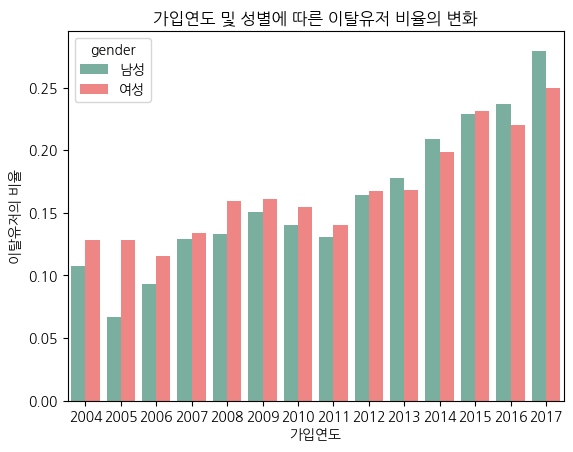

In [236]:
tmp = copy.deepcopy(members)
for idx, year in tmp.iterrows():
    tmp.loc[idx, 'year'] = tmp.loc[idx, 'registration_init_time'].year
tmp = tmp.astype({'year' : 'int'})
tmp = pd.merge(tmp, train, on = 'msno_num', how = 'inner')

tmp.replace({'gender' : {'female' : '여성', 'male' : '남성'}}, inplace=True)
sns.barplot(x = 'year',
            y ='is_churn', 
            data = tmp, 
            hue = 'gender', 
            palette=['#72B6A1', '#FF7575'], 
            errorbar = ('ci', False))
plt.xlabel('가입연도')
plt.ylabel('이탈유저의 비율')
plt.title('가입연도 및 성별에 따른 이탈유저 비율의 변화')
plt.show()

### **10대 후반 ~ 20대 초반의 사용자가 타 연령대에 비해 이탈 유저의 비율이 높음**

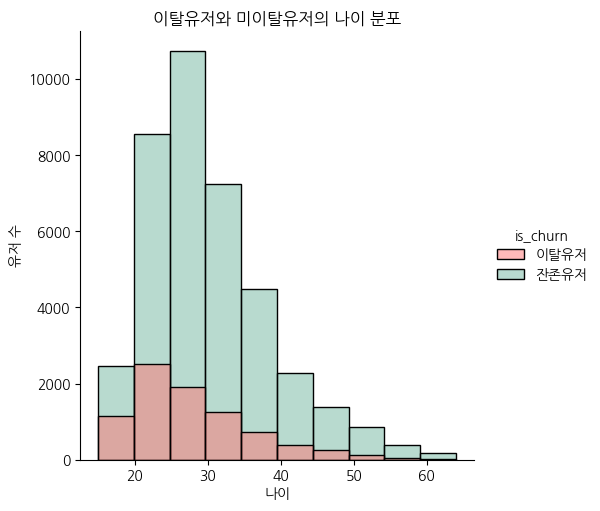

In [61]:
tmp = pd.merge(members, train, on = 'msno_num', how = 'inner')
tmp = tmp[(tmp['bd']>=15) & (tmp['bd']<=64)] # 경제활동인구 연령을 대상으로 함
tmp.replace({'is_churn' : {0 : '잔존유저', 1 : '이탈유저'}}, inplace = True)

sns.displot(data = tmp, x = 'bd',
            hue = 'is_churn', 
            hue_order = ['이탈유저', '잔존유저'], 
            bins = 10, 
            palette = ['#FF7575', '#72B6A1'])
plt.xlabel('나이')
plt.ylabel('유저 수')
plt.title('이탈유저와 미이탈유저의 나이 분포')
plt.show()

### **가입경로에 따라 이탈율에 큰 차이를 보임**

* 가입경로가 7인 유저의 이탈율이 가장 낮았고, 가입경로가 9인 유저의 이탈율이 가장 높았음
* 본 데이터셋에서는 가입경로가 코드화되어 있을 뿐, 실제 어떤 경로를 뜻하는지는 알 수 없었기 때문에 추가적인 확인은 불가능했음

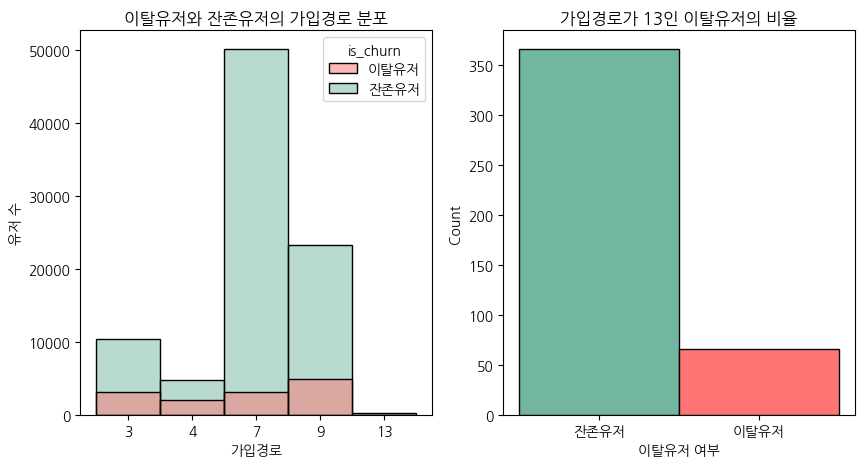

In [70]:
fig, ax = plt.subplots(figsize = (10, 5), ncols = 2)

tmp = pd.merge(members, train, on = 'msno_num', how = 'inner')
tmp.replace({'is_churn' : {0 : '잔존유저', 1 : '이탈유저'}}, inplace = True)
tmp.sort_values('registered_via', inplace = True, ascending=True)
tmp = tmp.astype({'registered_via' : 'str'})

sns.histplot(data = tmp,
             x = 'registered_via',
             hue = 'is_churn',
             hue_order = ['이탈유저', '잔존유저'], 
             palette = ['#FF7575', '#72B6A1'],
             ax = ax[0])
ax[0].set_xlabel('가입경로')
ax[0].set_ylabel('유저 수')
ax[0].set_title('이탈유저와 잔존유저의 가입경로 분포')

second_fig = sns.histplot(x = 'is_churn', 
                          data = tmp[tmp['registered_via']=='13'],
                          ax = ax[1])
second_fig.patches[0].set_facecolor('#72B6A1')
second_fig.patches[1].set_facecolor('#FF7575')
ax[1].set_xlabel('이탈유저 여부')
ax[1].set_title('가입경로가 13인 이탈유저의 비율')
plt.show()

## **사용 기록 관련**

### **음원 재생 관련 데이터 (재생한 곡 수, 일일 재생시간)에 이상치가 확인됨**

* 음원의 최소 길이를 대략 1분 정도라고 가정하고 하루종일 음원을 재생한다고 해도 최대 1,440번을 재생할 수 있음
* 그러나 본 데이터에서는 재생 횟수가 2,000을 훌쩍 넘는 이상치가 확인되어 이에 전처리가 필요한 상황임
* 또한, 일일 재생시간도 9.22337e+15, 9.22337e-15와 같이 비정상적으로 높거나 낮은 데이터가 확인되어 조치가 필요함

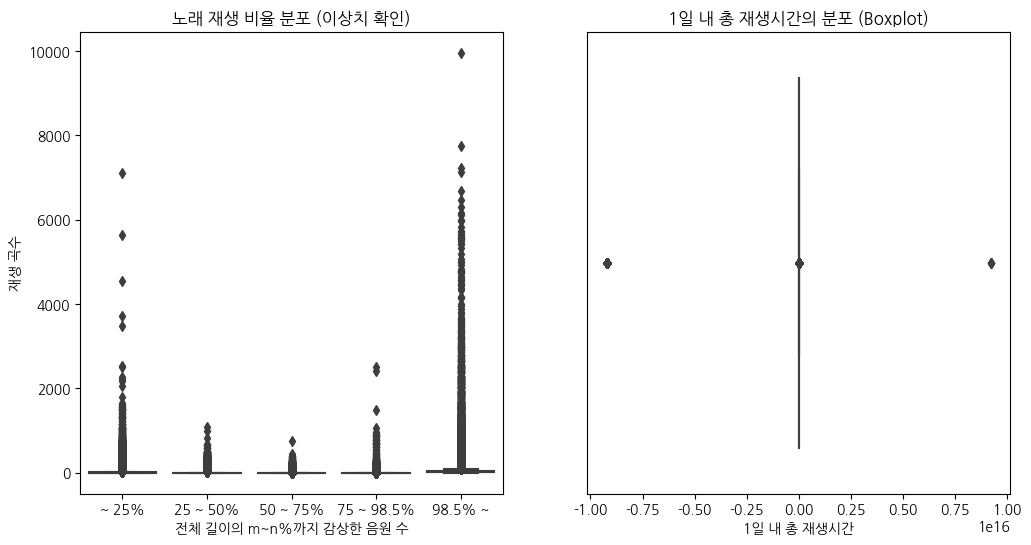

In [92]:
fig, ax = plt.subplots(figsize = (12, 6), ncols = 2)

cols = list(user_logs.columns)[2:7]
sns.boxplot(data = user_logs[cols], ax = ax[0])
ax[0].set_xticklabels(['~ 25%', '25 ~ 50%', '50 ~ 75%', '75 ~ 98.5%', '98.5% ~'])
ax[0].set_xlabel('전체 길이의 m~n%까지 감상한 음원 수')
ax[0].set_ylabel('재생 곡수')
ax[0].set_title('노래 재생 비율 분포 (이상치 확인)')

sns.boxplot(data = user_logs[['total_secs']], orient = 'h', ax = ax[1])
ax[1].set_xlabel('1일 내 총 재생시간')
ax[1].set_title('1일 내 총 재생시간의 분포 (Boxplot)')
ax[1].tick_params(left = False)
ax[1].set(yticklabels = [])

plt.show()

### **사용 기록이 많은 고객일 수록 이탈율이 낮음**

* 단조적으로 하강하는 형태는 아니지만, 로그가 많이 기록된 고개일 수록 이탈율이 낮아지는 그래프를 확인할 수 있음

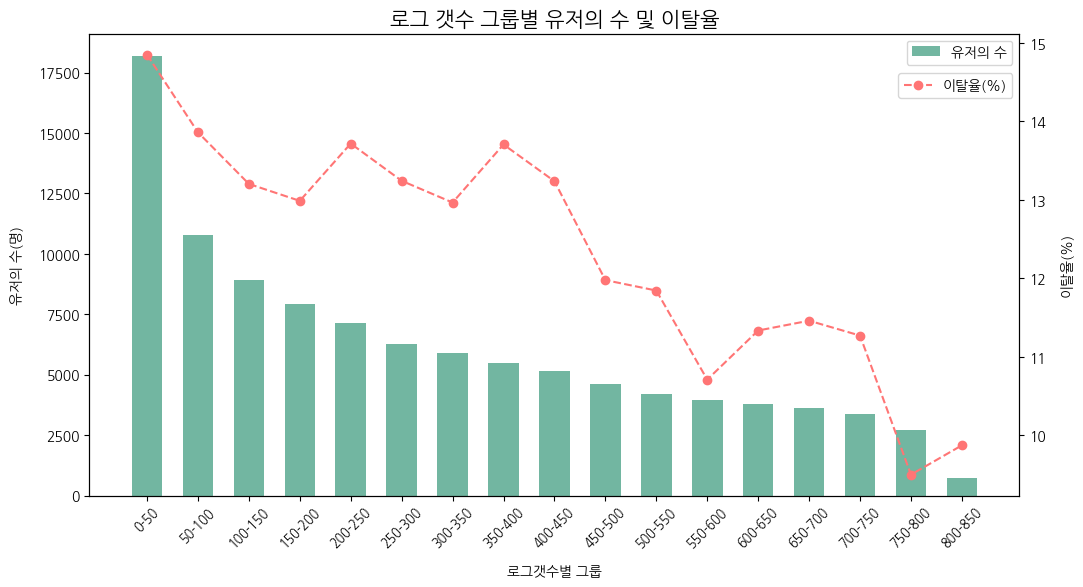

In [87]:
tmp = user_logs.groupby(['msno_num']).agg({'date' : 'count', 'total_secs' : 'sum'})
member_train_log = pd.merge(train, tmp , on = 'msno_num', how = 'inner')

bins = [n*50 for n in range(0, 18)]
labels = ["{}-{}".format(bins[i], bins[i+1]) for i in range(0, 17)]
member_train_log['date_count'] = pd.cut(member_train_log['date'], 
                                        bins= bins,
                                        labels=labels)

idx = np.array([i for i in range(17)])
tmp = pd.DataFrame(member_train_log.groupby('date_count', as_index = False)['msno_num'].count())

plt.figure(figsize=(12, 6))
plt.bar(idx, tmp['msno_num'], width = 0.6, label = '유저의 수', color = '#72B6A1')
plt.xticks(idx, tmp['date_count'], fontsize = 9, rotation = 45)
plt.xlabel('로그갯수별 그룹', fontsize = 10, labelpad= 10)
plt.ylabel('유저의 수(명)', fontsize = 10, labelpad= 10)
plt.title('로그 갯수 그룹별 유저의 수 및 이탈율', fontsize = 15)
plt.legend(loc = 0)

tmp = pd.DataFrame(member_train_log.groupby(['date_count', 'is_churn'], 
                   as_index = False)['msno_num'].count())
tmp = pd.merge(tmp[tmp['is_churn'] == 0], 
               tmp[tmp['is_churn'] == 1], 
               on = 'date_count', 
               how = 'inner').drop(columns=['is_churn_x', 'is_churn_y'])
tmp['ratio'] = tmp['msno_num_y'] / (tmp['msno_num_x'] + tmp['msno_num_y']) * 100
tmp.drop(columns=['msno_num_x', 'msno_num_y'], inplace=True)

line_plot = plt.twinx()
line_plot.plot(tmp['date_count'], 
               tmp['ratio'], 
               marker = 'o', 
               linestyle = '--', 
               color = '#FF7575', 
               label = '이탈율(%)')
line_plot.tick_params(axis = 'y', labelsize = 10)
line_plot.set_ylabel('이탈율(%)', fontsize = 10, labelpad= 10)
line_plot.legend(bbox_to_anchor = (1, 0.93))

plt.show()

### **이탈 유저의 경우 장기간 미접속 경험 비율이 높음**

* 잔존 유저의 경우 30일 이상 미접속한 경험을 가진 비율이 37%인 반면, 이탈 유저의 경우 그 비율이 46%에 달해 대략 10% 가량의 큰 차이를 보였음

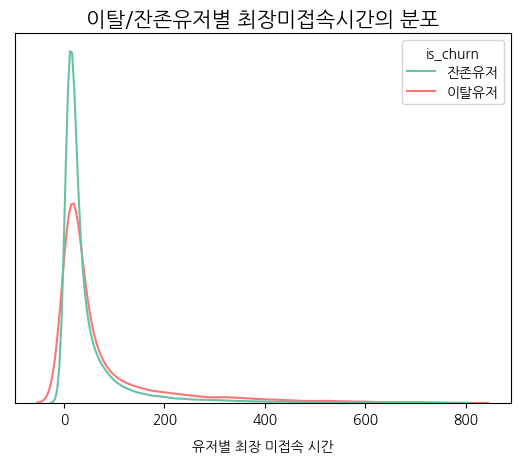

In [350]:
def remove_negative(df):
    df = df[(df['total_secs'] >= 0)&
            (df['num_25'] >= 0)&
            (df['num_50'] >= 0)&
            (df['num_75'] >= 0)&
            (df['num_985'] >= 0)&
            (df['num_100'] >= 0)&
            (df['num_unq'] >= 0)]
    return df

def remove_over_day(df):
   df = df[df['total_secs'] <= 86400]
   return df

def remove_quantile(df):
    for col in ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq']:
        df2 = df[df[col] > 0].copy()
        level_1q = df2[col].quantile(0.25)
        level_3q = df2[col].quantile(0.75)
        IQR = level_3q - level_1q
        rev_range = 1.5
        df = df[(df[col] <= level_3q+(rev_range*IQR)) & (df[col] >= level_1q-(rev_range*IQR))]    
    return df

df_new = (remove_quantile(remove_over_day(remove_negative(user_logs))))
df_new = df_new.sort_values('msno_num') 

df_new_sorted = df_new.sort_values(['msno_num', 'date'])
df_new_sorted['time_since_last_login'] = df_new_sorted.groupby('msno_num')['date'].diff().fillna(pd.Timedelta(seconds=0))
max_non_login_duration = df_new_sorted.groupby('msno_num')['time_since_last_login'].max().reset_index()
df_new_grouped_train = df_new_grouped_train.merge(max_non_login_duration, on = 'msno_num', how = 'inner')
df_new_grouped_train['time_since_last_login'] = df_new_grouped_train['time_since_last_login'].dt.days

sns.kdeplot(df_new_grouped_train, 
            x = 'time_since_last_login', 
            hue = 'is_churn',
            common_norm = False,
            palette = ['#66c2a5', '#ff7575'])
plt.gca().axes.yaxis.set_visible(False)
plt.xlabel('유저별 최장 미접속 시간', fontsize = 10, labelpad = 10)
plt.title('이탈/잔존유저별 최장미접속시간의 분포', fontsize = 15)
plt.show()

## **구매 기록 관련**

### **거래 일자와 구독 만료일 데이터에 이상치가 발견됨**

* 거래 일자와 구독 만료일 데이터에 아래와 같은 이상치가 발견됨
    * 동일 일자에 발생된 중복 거래 데이터
    * 거래 일자보다 구독 만료일이 이전인 데이터
    * 구독 만료일이 서비스 최초 시작 일자보다 이전이거나 구독 최대 연장 가능 기한※보다 이후인 데이터<br>
        ※ KKbox는 2005년에 서비스를 시작하였으며, 가입 시 30일의 무료 체험 기간을 주고 최대 1년까지 구독 연장이 가능함<br>
        ※ 본 데이터셋의 시점이 2017년 3월이었으므로, 구독 최대 연장 가능 기한은 2018년 4월 30일로 판단됨

In [119]:
tmp = copy.deepcopy(transactions)
min_timestamp = pd.Timestamp(datetime.date(2005, 1, 1))
max_timestamp = pd.Timestamp(datetime.date(2018, 4, 30))
filter = (tmp['membership_expire_date'] < min_timestamp) | (tmp['membership_expire_date'] > max_timestamp)

percent_1 = round(tmp[tmp.duplicated(subset = ['msno_num', 'transaction_date'], keep = False)].shape[0] / tmp.shape[0] * 100, 2)
percent_2 = round(tmp[tmp['transaction_date'] > tmp['membership_expire_date']].shape[0] / tmp.shape[0] * 100, 2)
percent_3 = round(tmp[filter].shape[0] / tmp.shape[0] * 100, 2)

print('동일 일자에 발생된 중복 거래 데이터는 전체 중 {}%입니다.'.format(percent_1))
print('거래 일자보다 구독 만료일이 이전인 데이터는 전체 중 {}%입니다.'.format(percent_2))
print('구독 만료일이 서비스 최초 시작 일자보다 이전이거나 구독 최대 연장 가능 기한 보다 이후인 데이터는 전체 중 {}%입니다.'.format(percent_3))

C:\Users\nuno3\AppData\Local\Temp\ipykernel_10280\893321536.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  filter = (tmp['membership_expire_date'] < min_timestamp) | (tmp['membership_expire_date'] > max_timestamp)


동일 일자에 발생된 중복 거래 데이터는 전체 중 2.66%입니다.
거래 일자보다 구독 만료일이 이전인 데이터는 전체 중 0.46%입니다.
구독 만료일이 서비스 최초 시작 일자보다 이전이거나 구독 최대 연장 가능 기한 보다 이후인 데이터는 전체 중 0.15%입니다.


In [120]:
# 동일 일자에 발생된 중복 거래 데이터
tmp[tmp.duplicated(subset = ['msno_num', 'transaction_date'], keep = False)].head(5)

,msno_num,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
33,4892,40,30,149,149,1,2016-11-23,2016-12-22,0
48,4892,40,30,149,149,1,2016-11-23,2016-11-21,1
407,45583,41,30,99,99,1,2017-01-04,2017-02-04,0
420,45583,41,30,149,149,1,2017-01-04,2017-01-04,1
427,45790,38,30,149,149,0,2016-07-31,2016-08-30,0


In [121]:
# 거래 일자보다 구독 만료일이 이전인 데이터
tmp[tmp['transaction_date'] > tmp['membership_expire_date']].head(5)

,msno_num,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
48,4892,40,30,149,149,1,2016-11-23,2016-11-21,1
115,13625,40,30,149,149,1,2016-08-24,2016-08-23,1
512,55265,41,30,149,149,1,2015-02-14,2015-02-13,1
547,56584,41,30,149,149,1,2015-12-24,2015-04-07,1
606,64005,41,30,149,149,1,2015-06-11,2015-06-10,1


In [123]:
# 구독 만료일이 서비스 최초 시작 일자보다 이전이거나 구독 최대 연장 가능 기한 보다 이후인 데이터
tmp[filter].head(5)

,msno_num,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
744,87244,24,30,149,149,1,2015-01-31,1970-01-01,1
1166,141423,41,30,149,149,1,2015-07-20,2018-09-18,1
1173,141423,41,30,129,129,1,2015-12-19,2019-07-30,0
1174,141423,41,30,149,149,1,2015-07-17,2018-10-15,0
1175,141423,41,30,149,149,1,2015-12-17,2019-06-29,0


### **고객이 선택하는 결제 수단에 따라 이탈율의 편차가 큼**

* 고객이 가장 자주 사용하는 결제 수단에 따라 이탈율을 확인한 결과, 0%에 가까운 수치부터 100%까지 편차가 매우 큼
* 적어도 5,000명 이상이 사용하는 결제 수단인 36, 38, 39, 40, 41 중, 38번 결제 수단의 이탈율이 40%에 달하여 높은 수준에 속함

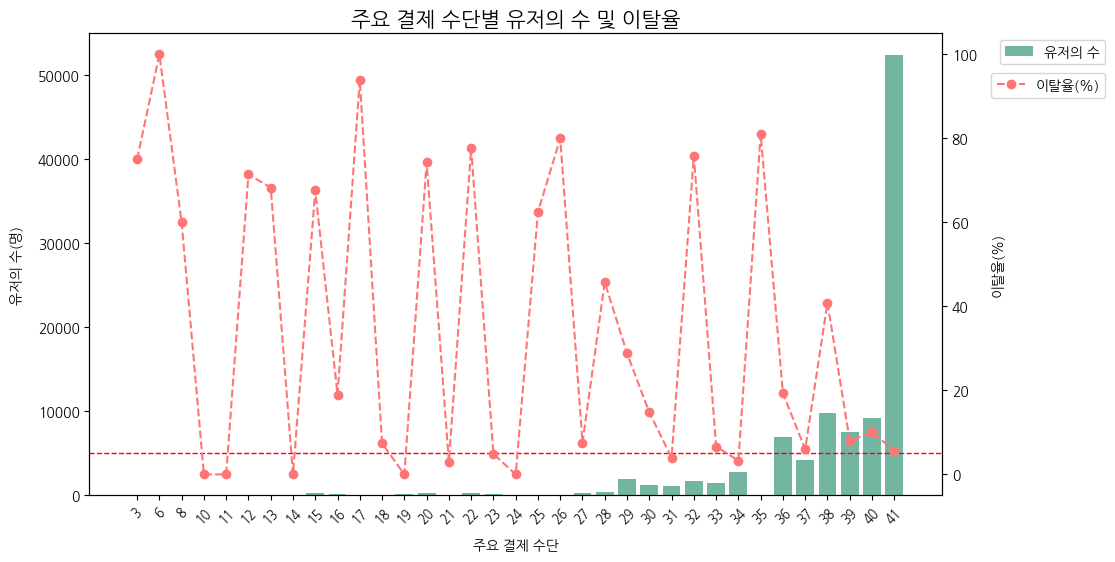

In [127]:
tmp = pd.DataFrame(transactions.groupby(['msno_num'], as_index = False)['payment_method_id'].apply(lambda x: x.mode().iloc[0]))\
                                                                                            .rename(columns = {'payment_method_id' : 'main_payment_method'})
tmp = pd.DataFrame(tmp.groupby('main_payment_method', as_index=False)['msno_num'].count())
tmp = tmp.astype({'main_payment_method' : 'str'})

idx = np.array([idx for idx in range(tmp['main_payment_method'].nunique())])

fig, ax = plt.subplots(figsize=(11,6))

plt.bar(idx, tmp['msno_num'], width = 0.8, label = '유저의 수', color = '#72B6A1')
plt.xticks(idx, tmp['main_payment_method'], fontsize = 9, rotation = 45)
plt.xlabel('주요 결제 수단', fontsize = 10, labelpad= 10)
plt.ylabel('유저의 수(명)', fontsize = 10, labelpad= 10)
plt.title('주요 결제 수단별 유저의 수 및 이탈율', fontsize = 15)
plt.axhline(y = 5000, color = 'r', linestyle = '--', linewidth = 1)
plt.legend(bbox_to_anchor = (1.2, 1))

tmp = pd.DataFrame(transactions.groupby(['msno_num'], as_index = False)['payment_method_id'].apply(lambda x: x.mode().iloc[0]))\
                                                                                            .rename(columns = {'payment_method_id' : 'main_payment_method'})
tmp = pd.merge(tmp, train, on = 'msno_num', how = 'inner')
tmp = pd.DataFrame(tmp.groupby(['main_payment_method', 'is_churn'], as_index=False)['msno_num'].count())
tmp = pd.merge(tmp[tmp['is_churn'] == 0], 
                 tmp[tmp['is_churn'] == 1], 
                 on = 'main_payment_method', how = 'outer').drop(columns=['is_churn_x', 'is_churn_y'])
tmp.fillna(0, inplace=True)
tmp = tmp.astype({'main_payment_method' : 'int'})
tmp.sort_values('main_payment_method', inplace = True)
tmp['ratio'] = tmp['msno_num_y'] / (tmp['msno_num_x'] + tmp['msno_num_y']) * 100
tmp.drop(columns=['msno_num_x', 'msno_num_y'], inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = tmp.astype({'main_payment_method' : 'str'})

line_plot = ax.twinx()
line_plot.plot(tmp['main_payment_method'], tmp['ratio'], marker = 'o', linestyle = '--', color = '#FF7575', label = '이탈율(%)')
line_plot.set_ylabel('이탈율(%)', fontsize = 10, labelpad= 10)
line_plot.legend(bbox_to_anchor = (1.2, 0.93))

plt.show()

### **이탈 유저는 구독 자동갱신 횟수가 적음**

* 이탈 유저의 경우, 잔존 유저와 비교하여 구독 자동 갱신을 전혀 하지 않은 비율이 3배 이상 높았음 (각각 약 15%, 약 4%)

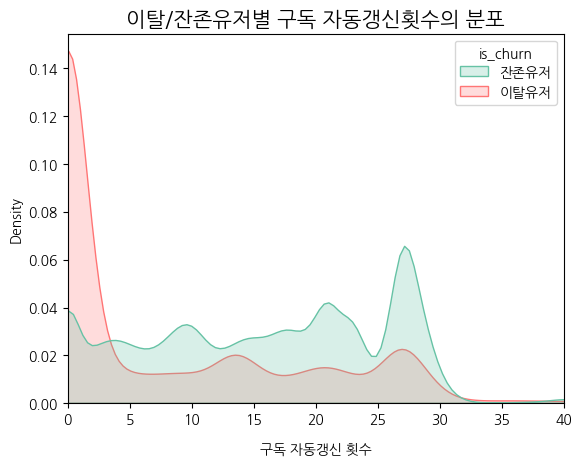

In [143]:
transaction_autorenew = transactions.groupby('msno_num')[['is_auto_renew']].sum()
train_autorenew =train.join(transaction_autorenew, on = 'msno_num', how = 'inner')
train_autorenew.replace({'is_churn' : {0 : '잔존유저', 1 : '이탈유저'}}, inplace = True)

sns.kdeplot(train_autorenew, 
            x = 'is_auto_renew', 
            hue = 'is_churn', 
            common_norm = False,
            palette = ['#66c2a5', '#ff7575'],
            fill = True)
plt.gca().axes.yaxis.set_visible(True)
plt.xlim([0, 40])
plt.xlabel('구독 자동갱신 횟수', fontsize = 10, labelpad = 12)
plt.title('이탈/잔존유저별 구독 자동갱신횟수의 분포', fontsize = 15)
plt.show()

### **구독 유지 기간이 길수록 이탈율은 낮아짐**

* 오랫동안 서비스를 이용한 고객보다 신규 고객의 이탈 가능성이 훨씬 더 높음

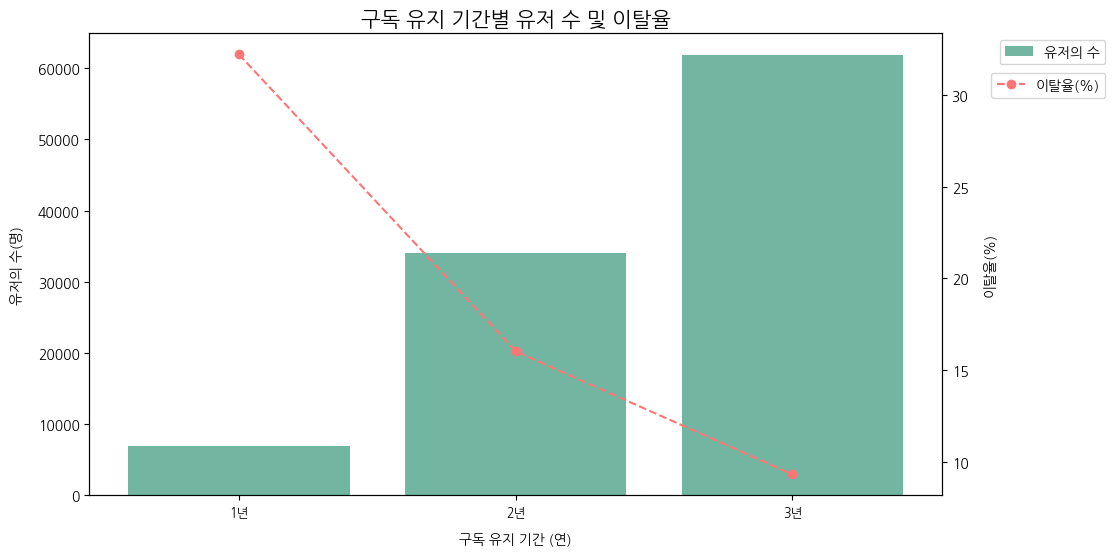

In [382]:
tmp = transactions.astype({'transaction_date': 'datetime64'})
tmp['year_month'] = tmp['transaction_date'].apply(lambda x: x.to_period('Y'))
tmp = tmp.drop_duplicates(subset=['msno_num', 'year_month'], keep='last')
tmp = tmp.groupby(['msno_num'])[['year_month']].count().reset_index()
tmp.rename(columns={'year_month': 'duration'},inplace=True)
tmp = pd.merge(tmp, train, on='msno_num',how='inner')
tmp = pd.DataFrame(tmp.groupby('duration', as_index=False)['msno_num'].count())
tmp = tmp.astype({'duration' : 'str'})
tmp.replace({'duration' : {'1':'1년 ', '2' : '2년', '3' : '3년'}}, inplace=True)

idx = np.array([idx for idx in range(tmp['duration'].nunique())])

fig, ax = plt.subplots(figsize=(11,6))

plt.bar(idx, tmp['msno_num'], width = 0.8, label = '유저의 수', color = '#72B6A1')

plt.xticks(idx, tmp['duration'], fontsize = 9)
plt.xlabel('구독 유지 기간 (연)', fontsize = 10, labelpad= 10)
plt.ylabel('유저의 수(명)', fontsize = 10, labelpad= 10)
plt.title('구독 유지 기간별 유저 수 및 이탈율', fontsize = 15)
plt.legend(bbox_to_anchor = (1.2, 1))

tmp = transactions.astype({'transaction_date': 'datetime64'})
tmp['year_month'] = tmp['transaction_date'].apply(lambda x: x.to_period('Y'))
tmp = tmp.drop_duplicates(subset=['msno_num', 'year_month'], keep='last')
tmp = tmp.groupby(['msno_num'])[['year_month']].count().reset_index()
tmp.rename(columns={'year_month': 'duration'},inplace=True)
tmp = pd.merge(tmp, train, on='msno_num',how='inner')
tmp_0 = pd.DataFrame(tmp.groupby(['duration', 'is_churn'], as_index=False)['msno_num'].count())
tmp_1 = tmp_0[tmp_0['is_churn']==0]
tmp_2 = tmp_0[tmp_0['is_churn']==1]
tmp_3 = pd.merge(tmp_1, tmp_2, on = 'duration', how = 'inner').drop(columns=['is_churn_x', 'is_churn_y'])
tmp_3.fillna(0, inplace=True)
tmp_3 = tmp_3.astype({'duration' : 'int'})
tmp_3.sort_values('duration', inplace=True)
tmp_3['ratio'] = tmp_3['msno_num_y'] / (tmp_3['msno_num_x'] + tmp_3['msno_num_y']) * 100
tmp_3.drop(columns=['msno_num_x', 'msno_num_y'], inplace=True)
tmp_3.reset_index(drop=True, inplace=True)
tmp_3 = tmp_3.astype({'duration' : 'str'})
tmp_3.replace({'duration' : {'1':'1년', '2' : '2년', '3' : '3년'}}, inplace=True)

line_plot = ax.twinx()
line_plot.plot(tmp_3['duration'], tmp_3['ratio'], marker = 'o', linestyle = '--', color = '#FF7575', label = '이탈율(%)')
line_plot.set_ylabel('이탈율(%)', fontsize = 10, labelpad= 10)
line_plot.legend(bbox_to_anchor = (1.2, 0.93))

plt.show()

### **가입 이후 결제 방식을 변경한 고객의 이탈율이 높음**

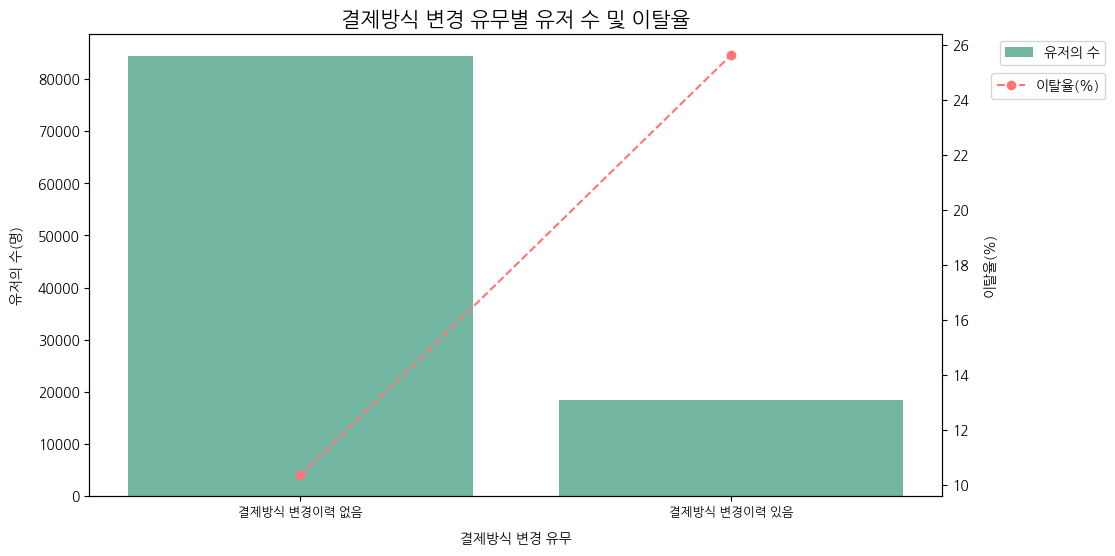

In [375]:
result_df = transaction_filtered.groupby('msno_num')[['payment_method_id']].nunique()
members_train_init = pd.merge(members, train, on = 'msno_num', how = 'inner')
member_transaction = pd.merge(result_df, members_train_init, on='msno_num', how = 'inner')
member_transaction['change'] = member_transaction['payment_method_id'].apply(lambda x: 1 if x>1 else 0) 
tmp = pd.DataFrame(member_transaction.groupby('change', as_index = False)['msno_num'].count())
tmp.replace({'change' : {0 : '결제방식 변경이력 없음', 1 : '결제방식 변경이력 있음'}}, inplace=True)

idx = np.array([0, 1])

fig, ax = plt.subplots(figsize=(11,6))

plt.bar(idx, tmp['msno_num'], width = 0.8, label = '유저의 수', color = '#72B6A1')

plt.xticks(idx, tmp['change'], fontsize = 9)
plt.xlabel('결제방식 변경 유무', fontsize = 10, labelpad= 10)
plt.ylabel('유저의 수(명)', fontsize = 10, labelpad= 10)
plt.title('결제방식 변경 유무별 유저 수 및 이탈율', fontsize = 15)
plt.legend(bbox_to_anchor = (1.2, 1))

result_df = transaction_filtered.groupby('msno_num')[['payment_method_id']].nunique()
members_train_init = pd.merge(members, train, on = 'msno_num', how = 'inner')
member_transaction = pd.merge(result_df, members_train_init, on='msno_num', how = 'inner')
member_transaction['change'] = member_transaction['payment_method_id'].apply(lambda x: 1 if x>1 else 0)
tmp = pd.DataFrame(member_transaction.groupby(['change', 'is_churn'], as_index = False)['msno_num'].count())
tmp_0 = tmp.replace({'change' : {0 : '결제방식 변경이력 없음', 1 : '결제방식 변경이력 있음'}})
tmp_1 = tmp_0[tmp_0['is_churn']==0]
tmp_2 = tmp_0[tmp_0['is_churn']==1]
tmp_3 = pd.merge(tmp_1, tmp_2, on = 'change', how = 'inner').drop(columns=['is_churn_x', 'is_churn_y'])
tmp_3.fillna(0, inplace=True)
tmp_3['ratio'] = tmp_3['msno_num_y'] / (tmp_3['msno_num_x'] + tmp_3['msno_num_y']) * 100
tmp_3.drop(columns=['msno_num_x', 'msno_num_y'], inplace=True)

line_plot = ax.twinx()
line_plot.plot(tmp_3['change'], tmp_3['ratio'], marker = 'o', linestyle = '--', color = '#FF7575', label = '이탈율(%)')
line_plot.set_ylabel('이탈율(%)', fontsize = 10, labelpad= 10)
line_plot.legend(bbox_to_anchor = (1.2, 0.93))

plt.show()